# Lung Segmentation


## import all packages



In [1]:
import os
import datetime
import time
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization,MaxPooling2D,Dense,concatenate
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate,Conv2DTranspose
from tensorflow.keras.layers import Input,UpSampling3D,Dense, Dropout,BatchNormalization, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.metrics import Recall, Precision,MeanIoU,AUC
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model



In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
IMAGE_SIZE = 256
EPOCHS = 50
BATCH = 4
LR = 1e-4

PATH = '../../data/1.shenzhen/'

# Load dataset

In [4]:
def load_data(path='../../data/1.shenzhen/', split=0.1,mode=''):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "masks/*")))
    
    if mode == 'training':
        total_size = len(images)
        valid_size = int(split * total_size)
        train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
        train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

        return (train_x, train_y), (valid_x, valid_y)
    
    if mode == 'testing':
        return (images,masks)

In [5]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

In [6]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([256, 256, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
#     dataset = dataset.repeat()
    return dataset


In [15]:
(train_x, train_y), (valid_x, valid_y) = load_data(PATH,mode='training')

print("Training data: ", len(train_x), len(train_y))
print("Validation data: ", len(valid_x))


Training data:  596 500
Validation data:  66


In [8]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

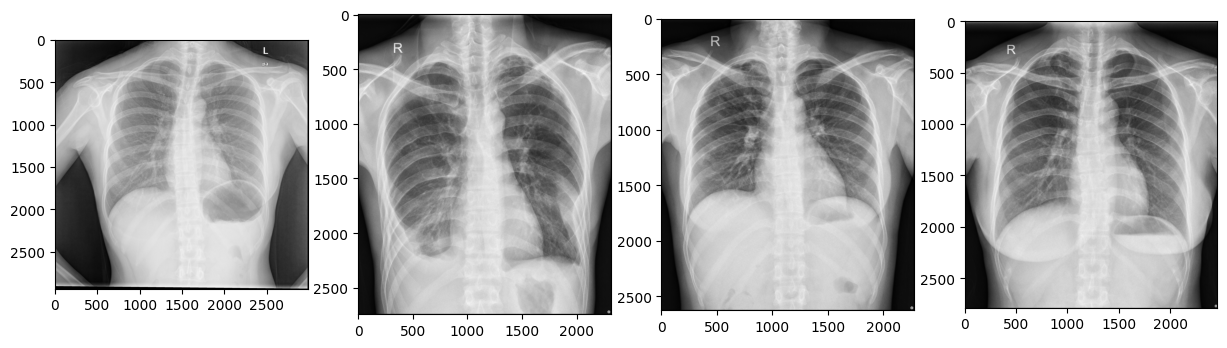

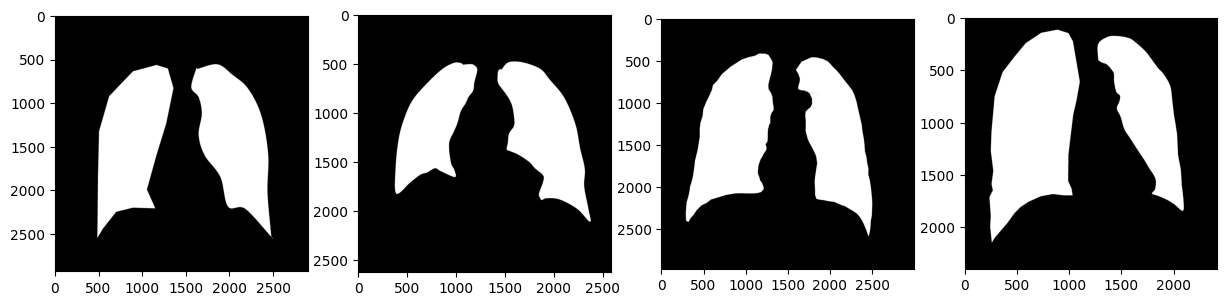

In [9]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(valid_x[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(valid_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(valid_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(valid_x[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(valid_y[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(valid_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(valid_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(valid_y[3]))
imgplot.set_clim(0.0, 1.4)

## load pretrained model from tensorflow 

In [10]:
def build_model(inputs):
    mobilenetv2 = tf.keras.applications.MobileNetV2(
        input_tensor = inputs, 
        weights="imagenet", include_top=False, alpha=0.35)
    mobilenetv2.trainable = False
    x = mobilenetv2.get_layer('out_relu').output
    x = Conv2D(128,3,name='final_conv',padding='same',activation='relu')(x)
    x = GlobalAveragePooling2D(name='gap')(x)
    output = Dense(2,activation='sigmoid')(x)
    return tf.keras.Model(inputs,output)


# build unet from the pretrained model 

https://github.com/nikhilroxtomar/Unet-with-Pretrained-Encoder/blob/master/U-Net_with_Pretrained_MobileNetV2_as_Encoder.ipynb

![image](https://github.com/nikhilroxtomar/Unet-with-Pretrained-Encoder/raw/5898a1e1ee66df875239d679839a30e419b20375//images/u-net-architecture.png)

In [11]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = build_model(inputs)
#     encoder.load_weights('../../output/checkpoints/mobilenetv2/512_128weights.16-0.31.hdf5')
    skip_connection_names = ["input_image","block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    f = [ 16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x =  Conv2DTranspose(filters=f[-i],kernel_size=3,strides=2,padding='same')(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    
    return model

In [12]:
model = model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 16  432         ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 16  64          ['Conv1[0][0]']                  
                                )                                                           

## Define Evaluatoin Metrics

In [13]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def jackard_index(y_true, y_pred):
    
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) -intersection + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)
def jackard_index_loss(y_true, y_pred):
    return 1.0 - jackard_index(y_true, y_pred)

In [14]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)


ValueError: Dimensions 596 and 500 are not compatible

In [ ]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, jackard_index, AUC(curve='PR'), Recall(), Precision()]
# model.load_weights('./output/unet_weights.19.0.03.hdf5')
model.compile(loss = jackard_index_loss, optimizer=opt, metrics=metrics)


In [ ]:
log_dir = "logs/unet/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir),
    ModelCheckpoint(
        './output/unet_weights.{epoch:02d}.{val_loss:.2f}.hdf5',
        monitor='val_loss',save_best_only=True,save_weights_only=True,verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

2022-09-08 10:33:46.056292: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-09-08 10:33:46.056302: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-09-08 10:33:46.056772: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


In [ ]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

hist = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=40,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

/Users/user/miniforge3/envs/Apple/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
2022-09-08 10:33:46.307048: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-08 10:33:46.307157: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/40


2022-09-08 10:33:47.575907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



  1/225 [..............................] - ETA: 8:47 - loss: 0.7879 - dice_coef: 0.3500 - jackard_index: 0.2121 - auc: 0.3186 - recall: 0.3703 - precision: 0.3506

2022-09-08 10:33:48.729354: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-09-08 10:33:48.729366: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.



  2/225 [..............................] - ETA: 1:02 - loss: 0.7895 - dice_coef: 0.3479 - jackard_index: 0.2105 - auc: 0.3187 - recall: 0.3794 - precision: 0.3579

2022-09-08 10:33:48.948919: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-09-08 10:33:48.949994: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-09-08 10:33:48.951309: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/unet/20220908-103346/train/plugins/profile/2022_09_08_10_33_48
2022-09-08 10:33:48.952403: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/unet/20220908-103346/train/plugins/profile/2022_09_08_10_33_48/users-MacBook-Pro.local.trace.json.gz
2022-09-08 10:33:48.953600: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/unet/20220908-103346/train/plugins/profile/2022_09_08_10_33_48
2022-09-08 10:33:48.953754: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/unet/20220908-103346/train/plugins/

225/225 [==============================] - ETA: 0s - loss: 0.3470 - dice_coef: 0.7735 - jackard_index: 0.6530 - auc: 0.9674 - recall: 0.9221 - precision: 0.8627

2022-09-08 10:34:35.182497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


225/225 [==============================] - 52s 224ms/step - loss: 0.3470 - dice_coef: 0.7735 - jackard_index: 0.6530 - auc: 0.9674 - recall: 0.9221 - precision: 0.8627 - val_loss: 0.2590 - val_dice_coef: 0.8511 - val_jackard_index: 0.7410 - val_auc: 0.9946 - val_recall: 0.9766 - val_precision: 0.9584

Epoch 00001: val_loss improved from inf to 0.25897, saving model to ./output/unet_weights.01.0.26.hdf5
Epoch 2/40
225/225 [==============================] - 50s 223ms/step - loss: 0.1317 - dice_coef: 0.9292 - jackard_index: 0.8683 - auc: 0.9935 - recall: 0.9720 - precision: 0.9690 - val_loss: 0.1208 - val_dice_coef: 0.9357 - val_jackard_index: 0.8792 - val_auc: 0.9929 - val_recall: 0.9495 - val_precision: 0.9890

Epoch 00002: val_loss improved from 0.25897 to 0.12081, saving model to ./output/unet_weights.02.0.12.hdf5
Epoch 3/40
225/225 [==============================] - 49s 218ms/step - loss: 0.0857 - dice_coef: 0.9552 - jackard_index: 0.9143 - auc: 0.9932 - recall: 0.9713 - precision: 0

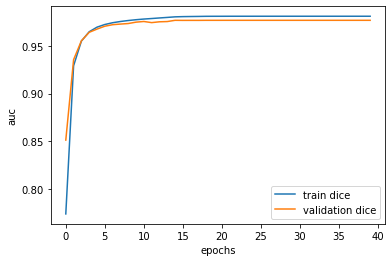

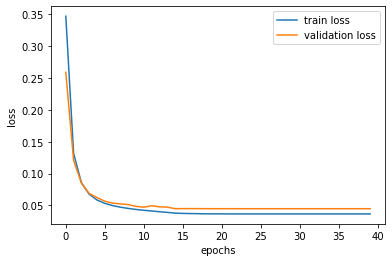

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['dice_coef'])
plt.plot(hist.history['val_dice_coef'])
plt.legend(['train dice','validation dice'])
plt.ylabel('auc')
plt.xlabel('epochs')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history[ 'val_loss'])
plt.legend(['train loss','validation loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()



In [ ]:
import pickle
filename = 'models/lung_area_segmentation.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
model.load_weights('./output/unet_weights.30.0.04.hdf5')
model.compile(loss = dice_loss, optimizer=opt, metrics=metrics)

ValueError: Cannot assign to variable conv2d_17/kernel:0 due to variable shape (1, 1, 16, 1) and value shape (1, 16, 3, 3) are incompatible

In [ ]:
test_x, test_y= load_data(path='./dataset/LSP/test/',mode='testing')
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

print("test data: ", len(test_x))
test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1
    

test data:  138


In [ ]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x


In [ ]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask


2022-09-08 11:25:22.047987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


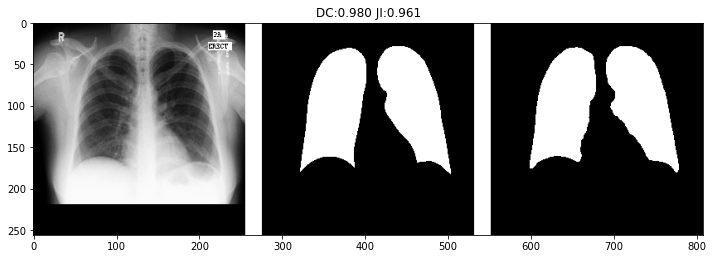

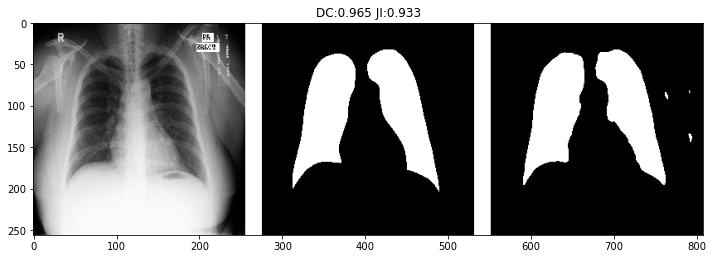

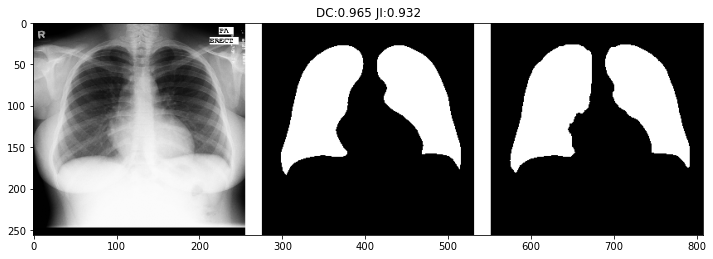

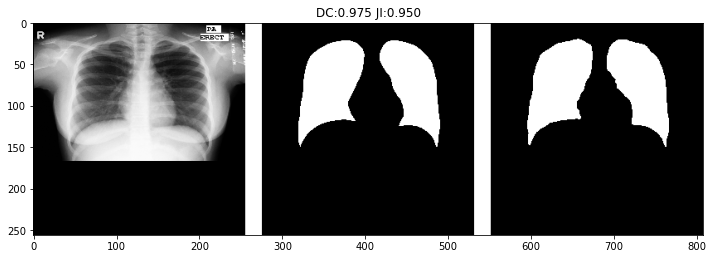

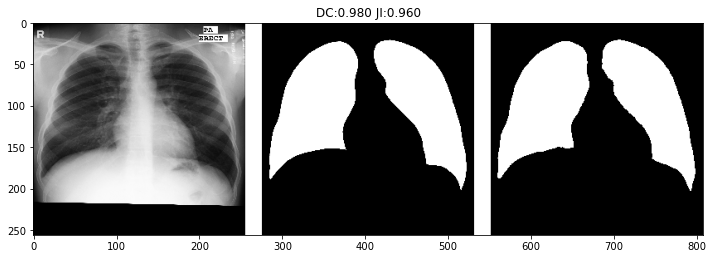

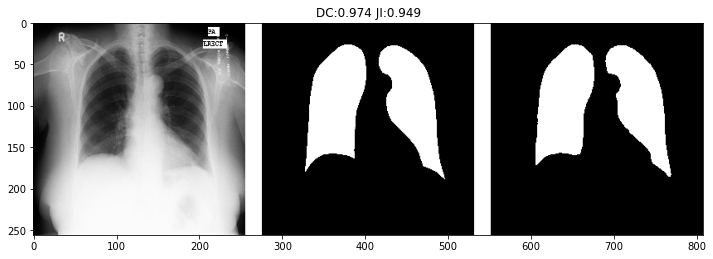

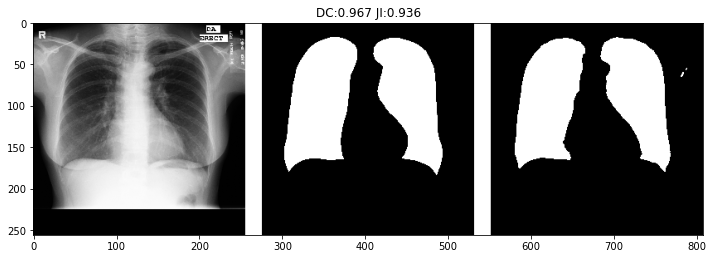

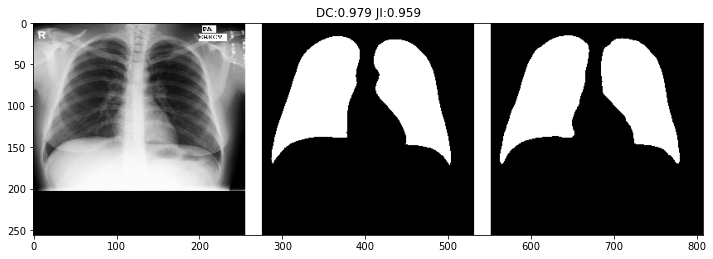

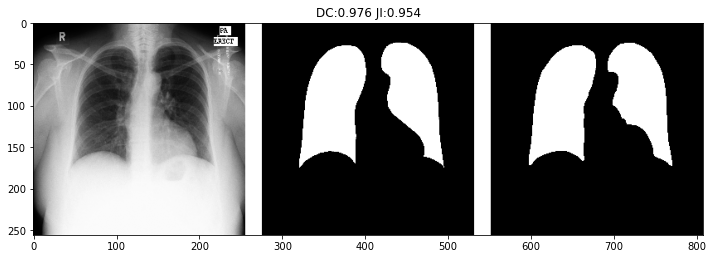

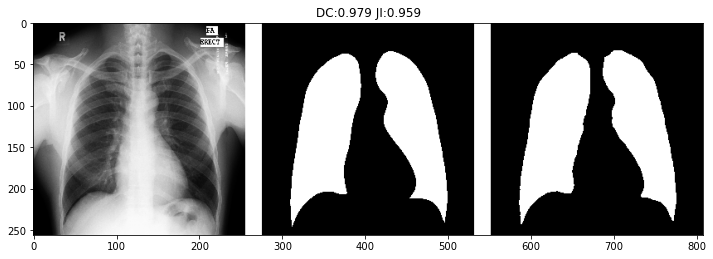

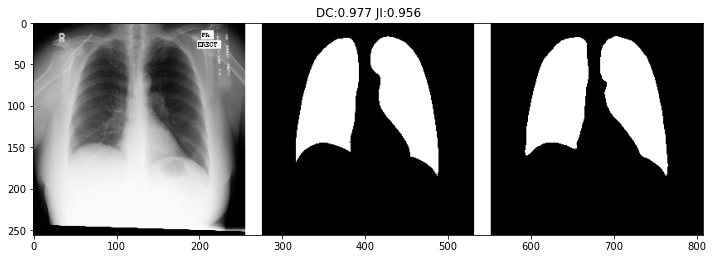

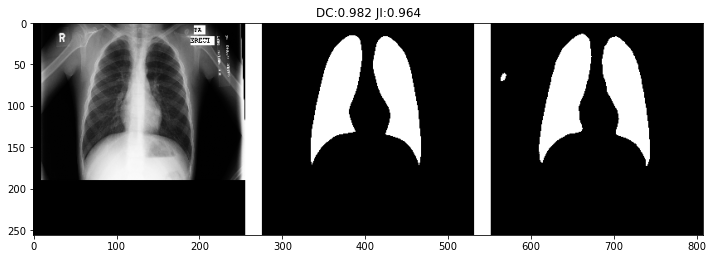

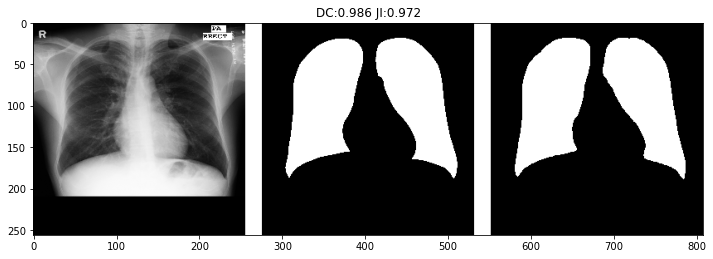

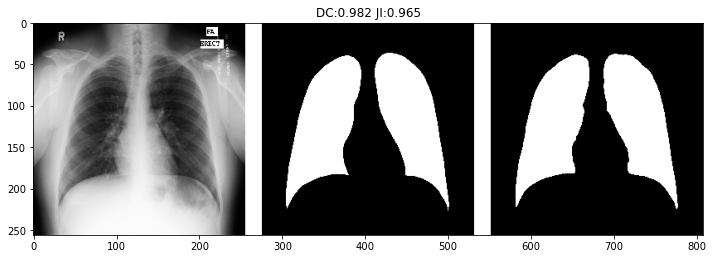

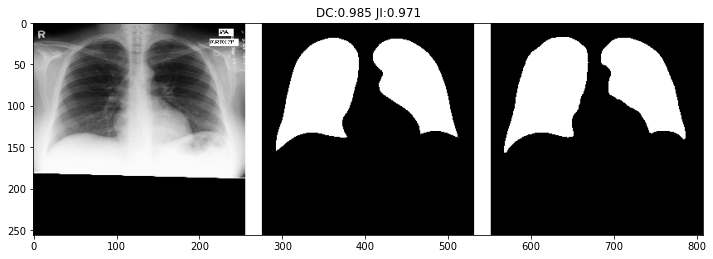

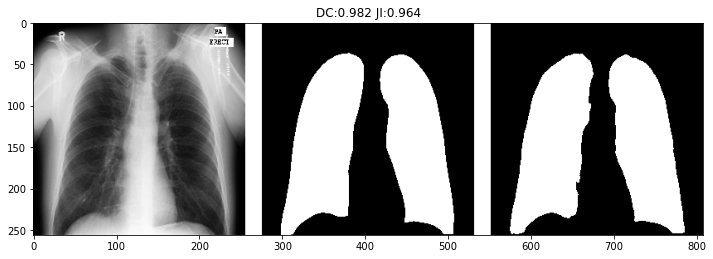

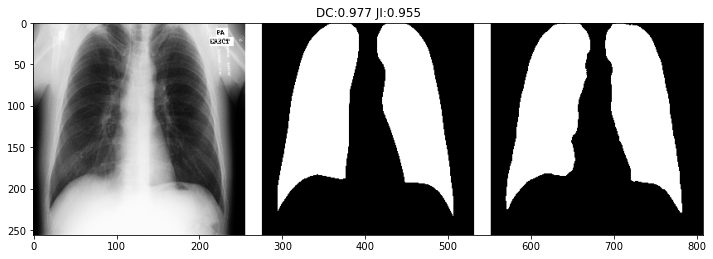

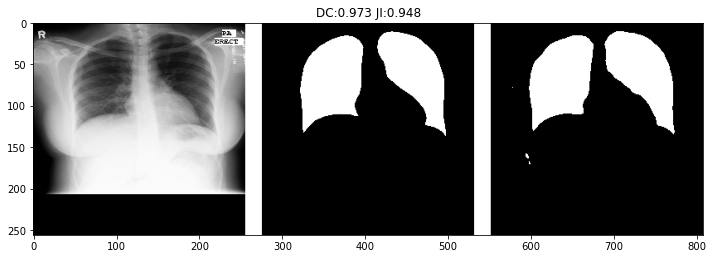

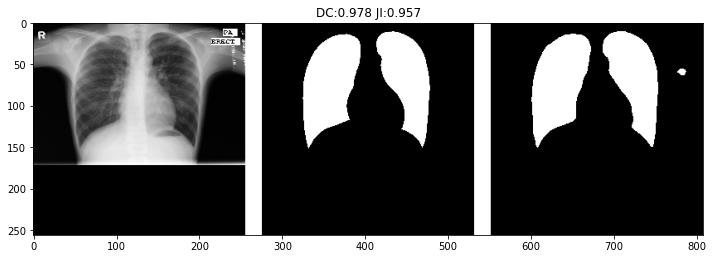

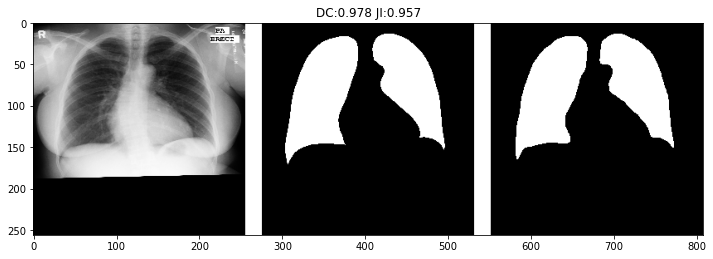

In [ ]:
for i, (x, y) in enumerate(zip(test_x[:20], test_y[:20])):
    x = read_image(x)
    y = read_mask(y)
    
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    
    h, w, _ = x.shape
    white_line = np.ones((h, 20, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)
    
    yp = np.where(y_pred == True, 1.0, 0.0)
    fig = plt.figure(figsize=(12, 12)) 
    a = fig.add_subplot(1, 1, 1)
    a.axes.set_title('DC:{:.3f} JI:{:.3f}'.format(dice_coef(y,yp),jackard_index(y,yp)))
    imgplot = plt.imshow(image)
    
    

In [ ]:
dicecoef=0
jackardindex=0
for  i, (x, y) in enumerate(zip(test_x, test_y)):
    x = read_image(x)
    y = read_mask(y)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    yp = np.where(y_pred == True, 1.0, 0.0)
    

    dicecoef += dice_coef(y,yp)
    jackardindex += jackard_index(y,yp)
    
print('DC:{:.3f} JI:{:.3f}'.format(dicecoef/138,jackardindex/138))

DC:0.972 JI:0.946
